In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pyia import GaiaData

In [12]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta.fits')
allstar = allstar[
    (allstar['LOGG'] > 0) & (allstar['LOGG'] < 6) &        
    (allstar['TEFF'] > 3500) & (allstar['TEFF'] < 7500) & 
    (allstar['FE_H'] > -2) & (allstar['FE_H'] < 0.6) & 
    (allstar['MG_FE'] > -1) & (allstar['MG_FE'] < 1) & 
    np.array(['BAD' not in allstar['ASPCAPFLAGS']])]
allstar = allstar[np.unique(allstar['APOGEE_ID'], return_index=True)[1]]

In [13]:
# elems = ['FE_H'] + [x for x in allstar.colnames if x.endswith('_FE')]
elems = [
 'FE_H',
 'C_FE',
 'N_FE',
 'O_FE',
 'NA_FE',
 'MG_FE',
 'AL_FE',
 'SI_FE',
 'CA_FE',
 'TI_FE',
 'V_FE',
 'CR_FE',
 'MN_FE',
 'CO_FE',
 'NI_FE',
 'CU_FE']

In [14]:
for col in allstar.colnames:
    if col.startswith("GAIA"):
        allstar[col[5:].lower()] = allstar[col]
        
    elif col == 'RA':
        allstar.rename_column('RA', 'ra')
        
    elif col == 'DEC':
        allstar.rename_column('DEC', 'dec')
        
    elif col in ['VHELIO_AVG', 'VERR', 'APOGEE_ID']:
        pass
        
    elif col in elems or col[:-4] in elems: # ERR
        pass
    
    else:
        allstar.remove_column(col)

In [15]:
len(allstar)

531530

In [16]:
g = GaiaData(allstar)
g = g[(g.parallax / g.parallax_error) > 8]

In [17]:
len(g)

353714

In [18]:
c = g.get_skycoord(radial_velocity=g.VHELIO_AVG*u.km/u.s)

In [19]:
idx, sep, dist = coord.match_coordinates_3d(c, c, nthneighbor=2)

mask = (dist < 25*u.pc)
c1 = c[mask]
c2 = c[idx[mask]]

In [20]:
delem = {}
delemerr = {}
for elem in elems:
    delem[elem] = g.data[mask][elem] - g.data[idx[mask]][elem]
    
    eerr = elem + '_ERR'
    delemerr[eerr] = np.sqrt(g.data[mask][eerr]**2 + g.data[idx[mask]][eerr]**2)

In [21]:
dx = c1.data.to_cartesian() - c2.data.to_cartesian()
dv = c1.velocity - c2.velocity

dxmag = dx.norm()
dvmag = dv.norm()

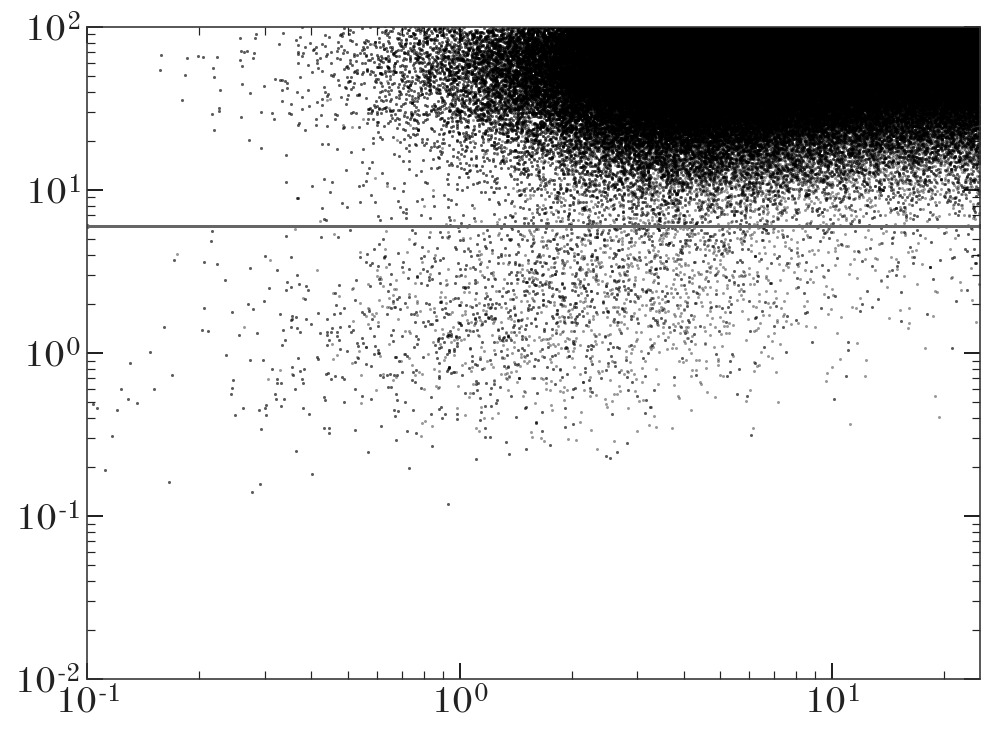

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(dxmag.value, dvmag.value, 
        marker='o', mew=0, ms=1.5, alpha=0.4, ls='none')
ax.set(xlim=(0.1, 25), ylim=(0.01, 100),
       xscale='log', yscale='log')
ax.axhline(6)

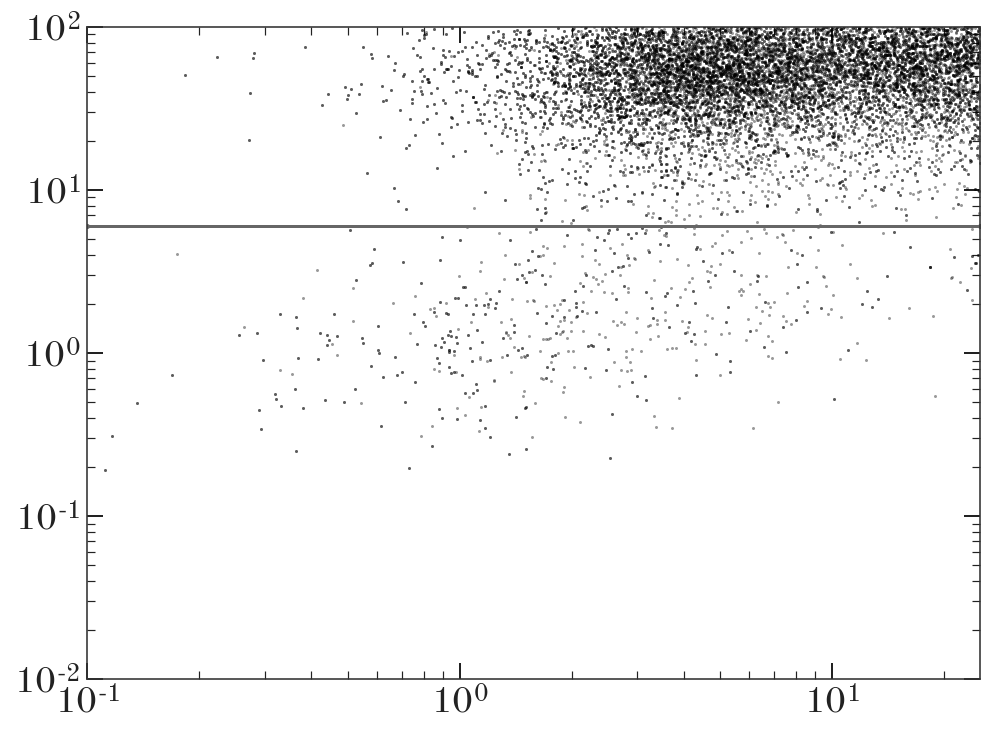

In [31]:
delem_mask = (np.abs(delem['FE_H']) < 0.05) & (np.abs(delem['MG_FE']) < 0.05)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(dxmag.value[delem_mask], dvmag.value[delem_mask], 
        marker='o', mew=0, ms=1.5, alpha=0.4, ls='none')
ax.set(xlim=(0.1, 25), ylim=(0.01, 100),
       xscale='log', yscale='log')
ax.axhline(6)

In [23]:
yomask = (dvmag < 8*u.km/u.s) & (dxmag > 2*u.pc)

[(-0.5, 0.5), (-0.5, 0.5)]

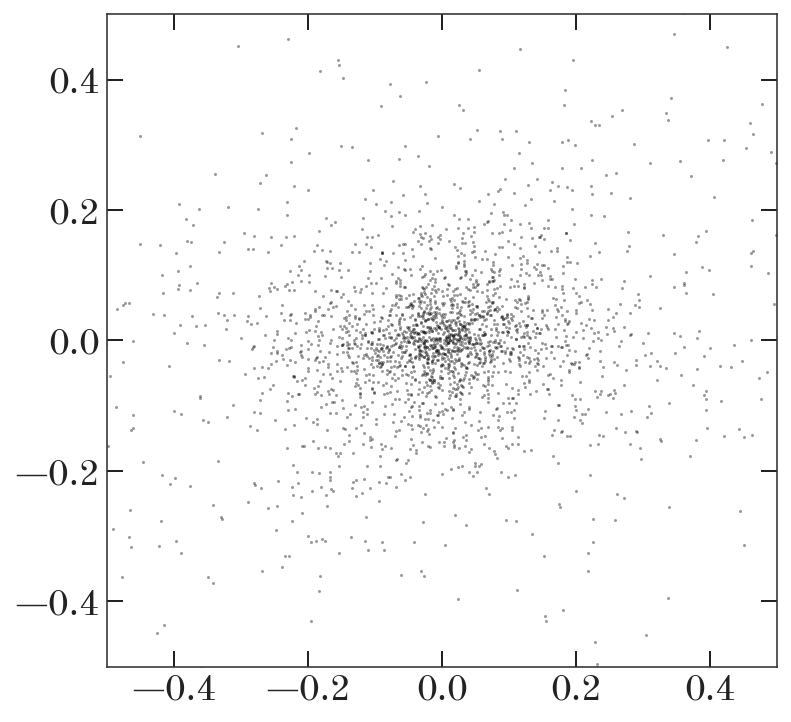

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(delem['FE_H'][yomask], 
        delem['MG_FE'][yomask],
        marker='o', mew=0, ms=1.5, alpha=0.4, ls='none')
ax.set(xlim=(-0.5, 0.5), ylim=(-0.5, 0.5))